# Dependencies

In [1]:
!pip install yolov5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.3/956.3 kB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 3.6 MB/s eta 0:00:0000:0100:01
  Using cached wget-3.2-py3-none-any.whl
  Using cached chardet-4.0.0-py2.py3-none-any.whl (178 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.

# Libraries

In [1]:
from typing import List
import torch
import torchvision as tv
from torchvision.models.feature_extraction import create_feature_extractor
import pydicom as dicom
import numpy as np
import cv2
import pandas as pd
import os
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast
from yolov5 import detect
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
import sys
from IPython.utils import io

# Helper Functions


### Common

In [2]:
DEVICE='cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2
EFFNET_CHECKPOINTS_PATH = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/checkpts'
N_FOLDS = 5
N_MODELS_FOR_INFERENCE = 2
yolo_model_path = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/best.pt'
train_bbox = pd.read_csv('/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')

In [3]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

### C1-C7 Detection

In [4]:
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

In [5]:
class VertebraeSegmentDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        # path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')
        path = os.path.join(self.path, f'{self.df.iloc[i].Slice}.dcm')
        try:
            img = load_dicom(path)[0]
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1' in self.df.columns:
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            return img, vert_targets
        return img

    def __len__(self):
        return len(self.df)


# ds_seg = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
# X, y = ds_seg[300]
# X.shape, y.shape

In [6]:
class SegEffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )
    
    def forward(self, x):
        x = self.model(x)['flatten']
        return self.nn_vertebrae(x)
    
    def predict(self, x):
        pred = self.forward(x)
        return torch.sigmoid(pred)

In [7]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [8]:
def get_dcm_data(dcm_path):
    dataset = dicom.read_file(dcm_path)
    observation_data = {
        "StudyInstanceUID" : dataset.get("SOPInstanceUID"),
        "Slice" : dataset.get("InstanceNumber"),
        "ImageHeight" : dataset.get("Rows"),
        "ImageWidth" : dataset.get("Columns"),
        "SliceThickness" : dataset.get("SliceThickness"),
        "ImagePositionPatient_x" : dataset.get("ImagePositionPatient")[0],
        "ImagePositionPatient_y" : dataset.get("ImagePositionPatient")[1],
        "ImagePositionPatient_z" : dataset.get("ImagePositionPatient")[2]
    }
    return observation_data


In [9]:
def make_pred_df(dcm_folder_path):
  list_dcm = os.listdir(dcm_folder_path)
  df_cols = ['StudyInstanceUID',	'Slice',	'ImageHeight',	'ImageWidth',	'SliceThickness',	'ImagePositionPatient_x',	'ImagePositionPatient_y',	'ImagePositionPatient_z']
  pred_df = pd.DataFrame(columns=df_cols)
  for dcm in list_dcm:
    dcm_data_dict = get_dcm_data(f'{dcm_folder_path}/{dcm}')
    pred_df = pred_df.append(dcm_data_dict, ignore_index = True)
  return pred_df
  

In [10]:
def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{EFFNET_CHECKPOINTS_PATH}/{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

In [11]:
def load_trained_models():
  seg_models = []
  for fold in range(N_FOLDS):
      fname = os.path.join(f'{EFFNET_CHECKPOINTS_PATH}/segeffnetv2-f{fold}.tph')
      if os.path.exists(fname):
          # print(f'Found cached model {fname}')
          seg_models.append(load_model(SegEffnetModel(), f'segeffnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH)[0].to(DEVICE))
  return seg_models

In [12]:
def predict_vertebrae(dcm_folder_path):
    seg_models = load_trained_models()
    df = make_pred_df(dcm_folder_path)
    ds = VertebraeSegmentDataSet(df, dcm_folder_path, WEIGHTS.transforms())
    # dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), collate_fn=filter_nones)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=filter_nones)

    predictions = []
    with torch.no_grad():
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, X in enumerate(progress):
                with autocast():
                    pred = torch.zeros(len(X), 7).to(DEVICE)
                    for model in seg_models:
                        pred += model.predict(X.to(DEVICE)) / len(seg_models)
                        # print(model.predict(X.to(DEVICE)))
                    predictions.append(pred)
    predictions = torch.concat(predictions).cpu().numpy()
    df.drop(df.columns[[2, 3, 4, 5, 6, 7]], axis=1, inplace=True)
    df[[f'C{i}' for i in range(1, 8)]] = predictions
    return df

### Fracture Detection

In [13]:
def save_as_img(path, i, new_path):
  patient_id = path.split('/')[-1]
  os.makedirs(f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_trials/{patient_id}', exist_ok=True)
  img = load_dicom(new_path)[0]
  filename = f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_trials/{patient_id}/{i}'.replace('dcm', 'png')
  if not os.path.isfile(filename):
    cv2.imwrite(filename, img)
    print('saving image')
  return filename, patient_id


In [14]:
def plot_fracture(slice_num,bbox_id,axes,ax_id1,ax_id2):
    file = dicom.dcmread(f"/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/{bbox_id}/{slice_num}.dcm")
    img = apply_voi_lut(file.pixel_array, file)
    info = train_bbox[(train_bbox['StudyInstanceUID']==bbox_id)&(train_bbox['slice_number']==slice_num)]
    rect = patches.Rectangle((float(info.x), float(info.y)), float(info.width), float(info.height), linewidth=3, edgecolor='r', facecolor='none')

    axes[ax_id1,ax_id2].imshow(img, cmap="bone")
    axes[ax_id1,ax_id2].add_patch(rect)
    axes[ax_id1,ax_id2].set_title(f"Label --> ID:{bbox_id}, Slice: {slice_num}", fontsize=10, weight='bold',y=1.02)
    axes[ax_id1,ax_id2].axis('off')

# Results

### C1-C7 Detection

In [15]:
from datetime import datetime
start=datetime.now()

In [16]:
path = '/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.20120'
# path = '/content/rnsa_cervical_spine_fracture_detection/train_images/1.2.826.0.1.3680043.10001'
patient_id = '1.2.826.0.1.3680043.20120'
# patient_id = '1.2.826.0.1.3680043.10001'
pred = predict_vertebrae(path)

Eval:   0%|          | 0/168 [00:00<?, ?it/s]

In [17]:
print(datetime.now()-start)

0:17:18.128896


In [18]:
col_val = ['C1','C2','C3','C4','C5','C6','C7']
for i in col_val:
  pred[col_val].astype(float)

# Fracture Detection

In [19]:
start=datetime.now()

In [20]:
for i in os.listdir(path):
  new_path = f'{path}/{i}'
  filename, patient_id = save_as_img(path, i, new_path)
  exp_path = i.replace('.dcm', '')
  project_dir = f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}'
  detect.run(source=filename, weights=yolo_model_path, imgsz=512, conf_thres=0.80, save_txt=True, save_conf=True, name=f'{exp_path}', project=project_dir)

YOLOv5 🚀 2023-4-11 Python-3.8.7 torch-1.12.1 CPU

Fusing layers... 
Model summary: 368 layers, 46143679 parameters, 0 gradients, 108.2 GFLOPs
image 1/1 /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_trials/1.2.826.0.1.3680043.20120/1.png: 512x512 (no detections), 2326.7ms
Speed: 3.4ms pre-process, 2326.7ms inference, 6.6ms NMS per image at shape (1, 3, 512, 512)
Results saved to /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/1.2.826.0.1.3680043.20120/1100
0 labels saved to /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/1.2.826.0.1.3680043.20120/1100/labels
YOLOv5 🚀 2023-4-11 Python-3.8.7 torch-1.12.1 CPU

Fusing layers... 
Model summary: 368 layers, 46143679 parameters, 0 gradients, 108.2 GFLOPs
image 1/1 /Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_trials/1.2.826.0.1.3680043.20120/10.png: 512x512 (no detections), 3168.8ms
Speed: 10.0ms pre-process, 3168.8ms inference, 1.3ms NMS per image at shape (1, 3, 512, 512)


In [21]:
print(start-datetime.now())

-1 day, 23:46:59.004395


In [22]:
print(datetime.now()-start)

0:13:01.206522


In [25]:
cols = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score', 'Slice', 'location']
frac_df = pd.DataFrame(columns=cols)
for i in range(1, len(pred)+1):
  if os.listdir(f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{i}/labels'):
    df = pd.read_csv(f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{i}/labels/{i}.txt', sep=" ", header=None)
    df.columns = ['class', 'x-center', 'y-center', 'bbox_width', 'bbox_height', 'conf-score']
    df['Slice'] = i
    df['location'] = f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{i}/{i}.png'
    frac_df = pd.concat([frac_df, df], axis=0)
  else:
    data = {'class': 0, 
            'x-center': '-', 
            'y-center': '-', 
            'bbox_width': '-', 
            'bbox_height': '-', 
            'conf-score': '-',
            'Slice': i,
            'location': f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{i}/{i}.png'}
    frac_df = frac_df.append(data, ignore_index = True)
  
  

In [26]:
for i in frac_df.Slice:
  temp = pred.loc[pred['Slice'] == i]
  max_val = temp.max(axis=1).values
  col_names = temp.columns.to_list()
  list_seg = []
  for j in col_names:
    if temp[j].values[0] == max_val[0]:
      frac_df.loc[i-1, 'C1-C7'] = j
frac_df.drop(frac_df.columns[[1, 2, 3, 4]], axis=1, inplace=True)
frac_df['file_loc'] = frac_df.apply(lambda x: f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{slice}')

In [26]:
frac_df.query("`class`==1")

,class,conf-score,Slice,C1-C7
163,1,0.811906,164,C2
183,1,0.826765,184,C4
184,1,0.852708,185,C2
185,1,0.854258,186,C4
186,1,0.858519,187,C4
...,...,...,...,...
273,1,0.826974,274,C2
274,1,0.818295,275,C2
275,1,0.809659,276,C2
276,1,0.818995,277,C2


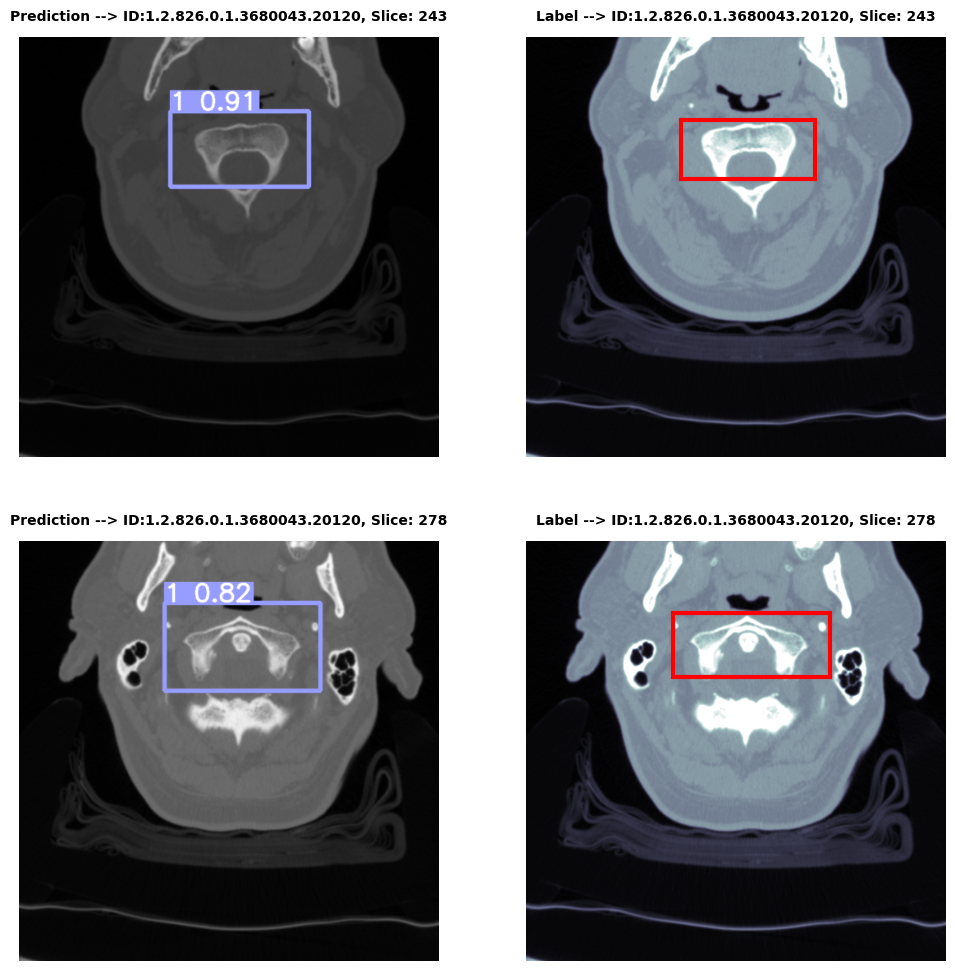

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

slice_no_1 = 243
slice_no_2 = 278

pred_img_1 = cv2.imread(f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{slice_no_1}/{slice_no_1}.png')
axes[0,0].imshow(pred_img_1)
axes[0,0].set_title(f"Prediction --> ID:{patient_id}, Slice: {slice_no_1}", fontsize=10, weight='bold',y=1.02)
axes[0,0].axis('off')

pred_img_2 = cv2.imread(f'/Volumes/SSD/rsna-2022-cervical-spine-fracture-detection/yolo_runs/{patient_id}/{slice_no_2}/{slice_no_2}.png')
axes[1,0].imshow(pred_img_2)
axes[1,0].set_title(f"Prediction --> ID:{patient_id}, Slice: {slice_no_2}", fontsize=10, weight='bold',y=1.02)
axes[1,0].axis('off')


plot_fracture(slice_no_1,patient_id,axes,0,1)

plot_fracture(slice_no_2,patient_id,axes,1,1)


  


### Effnetv2 accuracy per vertebrae 

##### C1 -> 0.96111558 
##### C2 -> 0.9414052  
##### C3 -> 0.95850094 
##### C4 -> 0.95974122 
##### C5 -0.94924913 
##### C6 -> 0.94686913
##### C7 -> 0.94656744

## Effnetv2 average accuracy -> 0.9519212351070757

#